In [1]:
# Cell 1: Setup – imports, DM test, lag selection, data loading, VAR endog block

from __future__ import annotations

import math
import warnings
from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")


# ----------------------------
# Diebold–Mariano test (Chronos-style, two-sided)
# ----------------------------
def _normal_cdf(z: float) -> float:
    """Standard normal CDF without scipy."""
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    """
    Diebold–Mariano test for equal predictive accuracy (Chronos-style).

    Parameters
    ----------
    y_true : pd.Series
        Realised values.
    y_model : pd.Series
        Forecasts from the model being evaluated.
    y_rw : pd.Series
        Forecasts from the benchmark model (e.g. random walk).
    h : int, default 1
        Forecast horizon. For non-overlapping horizons, h=1 is appropriate.
        For overlapping horizons, set h equal to the forecast horizon and
        a simple Newey–West/Bartlett HAC up to lag h-1 is used.
    loss : {"mse", "mae"}, default "mse"
        Loss function used to construct the loss differential.

    Returns
    -------
    dm_stat : float
        DM test statistic.
    p_val : float
        Two-sided p-value under asymptotic N(0, 1).
    """
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()

    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]

    if loss.lower() == "mae":
        d = np.abs(e_m) - np.abs(e_r)
    else:  # "mse"
        d = (e_m ** 2) - (e_r ** 2)

    N = int(len(d))
    d_mean = float(d.mean())

    # Variance of loss differential
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N if N > 0 else float("nan")

    # Simple Newey–West / Bartlett HAC if h > 1 (overlapping horizons)
    if h > 1 and N > 2 and np.isfinite(var_bar):
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


# ----------------------------
# Robust VAR lag selection
# ----------------------------
def choose_var_lag(
    train: pd.DataFrame,
    max_p: int,
    prev_p: Optional[int] = None,
) -> int:
    """
    Robustly choose VAR lag order to avoid numerical failures.

    - Restricts max feasible p based on T and k.
    - Tries statsmodels' select_order(AIC).
    - On failure, falls back to a conservative lag length.

    Parameters
    ----------
    train : DataFrame
        Endogenous block used for estimation (T x k).
    max_p : int
        Global upper bound on lag order.
    prev_p : int or None
        Previously used lag (for fallback consistency).

    Returns
    -------
    p : int
        Chosen lag order (>=1).
    """
    T, k = train.shape

    # Conservative feasible upper bound to avoid overparameterization
    p_feasible = max(1, min(max_p, (T - 1) // (k + 1)))
    if p_feasible < 1:
        return 1

    try:
        sel = VAR(train).select_order(maxlags=p_feasible)
        p = sel.selected_orders.get("aic", None)
        if p is None:
            p = prev_p if prev_p is not None else min(2, p_feasible)
    except Exception:
        p = prev_p if prev_p is not None else min(2, p_feasible)

    p = int(p)
    p = max(1, min(p, p_feasible))
    return p


# ----------------------------
# Data loading and endogenous block
# ----------------------------
url = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
)

df = pd.read_csv(url)

# Standardise the date index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
elif "DATE" in df.columns:
    df["Date"] = pd.to_datetime(df["DATE"])
else:
    raise KeyError("Neither 'Date' nor 'DATE' found in column names.")

df = df.sort_values("Date").set_index("Date")

print(f"Data from {df.index.min().date()} to {df.index.max().date()}")
print(f"Total observations: {len(df)}")

# Ensure required columns exist
required_cols = ["EUR_NOK", "d_pi", "dI_t", "Q"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in data: {missing}")

# Build endogenous block
df = df.copy()
df["s"] = np.log(df["EUR_NOK"])  # log spot EUR/NOK

endog_vars = ["s", "d_pi", "dI_t", "Q"]
endog = df[endog_vars].dropna()

dates = endog.index

print("\nEndogenous variables used in VAR:")
print(endog_vars)
print(f"Usable observations after dropna: {len(endog)}")


Data from 2000-01-31 to 2025-11-30
Total observations: 311

Endogenous variables used in VAR:
['s', 'd_pi', 'dI_t', 'Q']
Usable observations after dropna: 311



Monthly VAR – 1-step-ahead walk-forward (EUR/NOK)
Completed 275 monthly forecasts.

=== Model performance (monthly level, EUR/NOK – VAR) ===
Observations: 275
RMSE (level): 0.240012
MAE  (level): 0.175657
Directional accuracy: 136/274 (49.6%)

=== Diebold–Mariano vs Random Walk (VAR, monthly) ===
Loss: MSE | horizon h=1
DM-statistic: 1.8587
p-value     : 0.0631


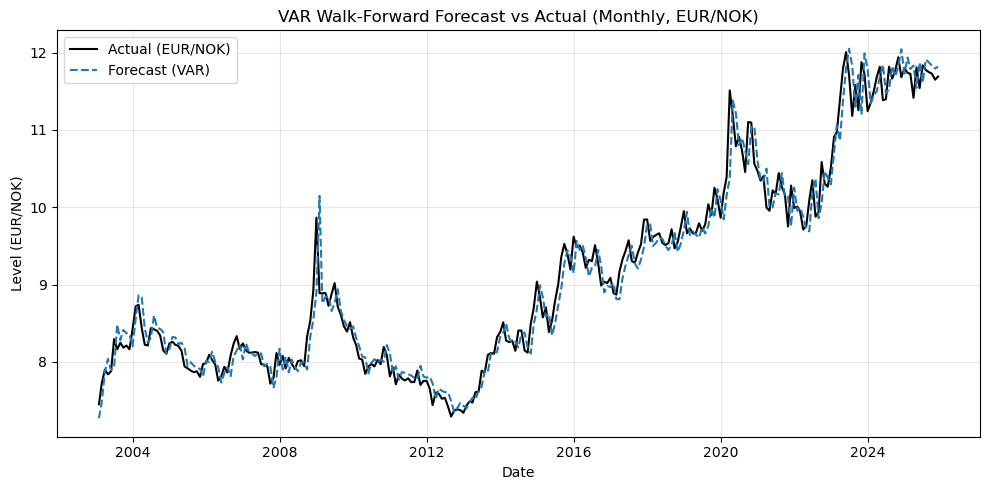


Average selected VAR lag (monthly): 2.51


In [2]:
# Cell 2: Monthly VAR – walk-forward forecast, evaluation, DM vs RW (EUR/NOK)

min_train_months = 36   # at least 3 years before first forecast
max_p = 6               # global max lag

rows_m: list[Dict] = []
prev_p_monthly: Optional[int] = None

for i in range(min_train_months, len(dates)):
    d_prev = dates[i - 1]  # last in-sample month
    d_curr = dates[i]      # month to forecast

    # Expanding window up to d_prev
    train = endog.loc[:d_prev]

    # Robust lag selection
    p = choose_var_lag(train, max_p=max_p, prev_p=prev_p_monthly)
    prev_p_monthly = p

    model = VAR(train).fit(p)
    y0 = train.values[-p:]

    # 1-step ahead forecast for full endogenous vector
    f_vec = model.forecast(y0, steps=1)[0]
    f = pd.Series(f_vec, index=endog_vars)

    # Realised values at d_curr
    obs = endog.loc[d_curr]

    rows_m.append(
        {
            "date": d_curr,
            # s in levels (EUR/NOK)
            "s_true": float(np.exp(obs["s"])),
            "s_pred": float(np.exp(f["s"])),
            "p_used": p,
        }
    )

df_eval_m = pd.DataFrame(rows_m).set_index("date").sort_index()

print("\n==============================")
print("Monthly VAR – 1-step-ahead walk-forward (EUR/NOK)")
print("==============================")
print(f"Completed {len(df_eval_m)} monthly forecasts.")


# ----- Evaluation (Chronos-style) -----
def evaluate_monthly_var(df_eval_m: pd.DataFrame) -> pd.DataFrame:
    """
    Compute level errors and directional accuracy for monthly VAR (EUR/NOK).

    Returns:
      eval_df with columns:
        y_true, y_pred (monthly EUR/NOK levels)
    """
    df = df_eval_m.copy()
    df["err"] = df["s_true"] - df["s_pred"]
    core = df.dropna(subset=["s_true", "s_pred"]).copy()

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(core["err"] ** 2))) if n_obs else np.nan
    mae = float(mean_absolute_error(core["s_true"], core["s_pred"])) if n_obs else np.nan

    # Directional accuracy vs previous month
    core["y_prev"] = core["s_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "s_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "s_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly level, EUR/NOK – VAR) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    eval_df = core[["s_true", "s_pred"]].rename(
        columns={"s_true": "y_true", "s_pred": "y_pred"}
    )
    return eval_df


def dm_against_random_walk_monthly(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """
    DM test vs random walk at monthly horizon.

    Random walk benchmark: RW_t = y_{t-1}.
    """
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)

    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (VAR, monthly) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    if np.isfinite(dm_stat):
        print(f"DM-statistic: {dm_stat:.4f}")
    else:
        print("DM-statistic: nan")
    if np.isfinite(p_val):
        print(f"p-value     : {p_val:.4f}")
    else:
        print("p-value     : nan")


# Run evaluation + DM
eval_m = evaluate_monthly_var(df_eval_m)
dm_against_random_walk_monthly(eval_m, loss="mse", h=1)

# Optional: plot monthly actual vs VAR forecast
plt.figure(figsize=(10, 5))
plt.plot(
    df_eval_m.index,
    df_eval_m["s_true"],
    label="Actual (EUR/NOK)",
    color="black",
)
plt.plot(
    df_eval_m.index,
    df_eval_m["s_pred"],
    linestyle="--",
    label="Forecast (VAR)",
)
plt.title("VAR Walk-Forward Forecast vs Actual (Monthly, EUR/NOK)")
plt.xlabel("Date")
plt.ylabel("Level (EUR/NOK)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAverage selected VAR lag (monthly): {df_eval_m['p_used'].mean():.2f}")
